# **Predvidjanje otkaza zaposlenih pomocu razlicitih metoda binarne klasifikacije**

## Uvod

Cilj ovog projekta je predviđanje
otkaza zaposlenih pomoću različitih metoda analize podataka.
Podaci o zaposlenima uključuju različite faktore kao što su nivo obrazovanja,
radni staž, lokacija u kojoj su zaposleni, nivo plate... Cilj je razviti modele koji
su sposobni da predviđaju moguće otkaze zaposlenih na osnovu ovih podataka.
Postoje mnogi modeli koji mogu biti korisni za rešavanje ovog problema.
Ovaj rad će se pretežno baviti korišćenjem modela Logistic Regression, Decision
Tree, Random Forests i Extreme Gradient Boosting, kako bi se postiglo što
uspešnije predviđanje otkaza


Podaci su sačinjeni od 9 kolona (atributa) i 4563 reda. Kolona čiju vrednost
želimo da predvidimo je LeaveOrNot koja ukazuje na to da li zaposleni napušta
firmu.

### Biblioteke i podaci nad kojima se vrsi predikcija

In [551]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2, SelectKBest

In [552]:
df = pd.read_csv("Employee.csv")
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [553]:
print(df.columns[df.isnull().any()])

Index([], dtype='object')


Podaci govore o 4653 zaposlena i sve vrednosti su ispravno unete.

# Vizuelizacija podataka

Potrebno je vizuelizovati podatke sa kojima se radi, kako bi se mogli izvuci zakljucci na osnovu posmatranih podataka.

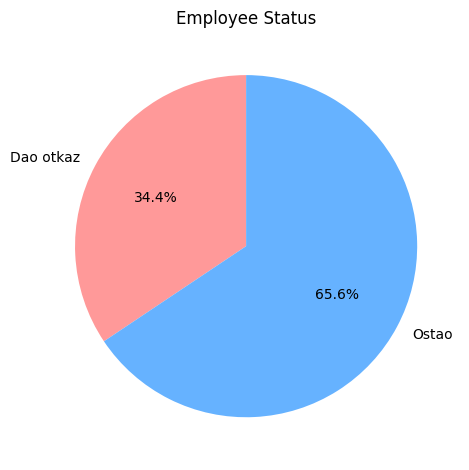

In [554]:
left_percentage = (df['LeaveOrNot'].sum() / len(df)) * 100
not_left_percentage = 100 - left_percentage


vrednosti = ['Dao otkaz', 'Ostao']

values = [left_percentage, not_left_percentage]

boje = ['#FF9999', '#66B2FF']

plt.pie(values, labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Employee Status')

plt.tight_layout()
plt.show()


### Uticaj privremene besposlice

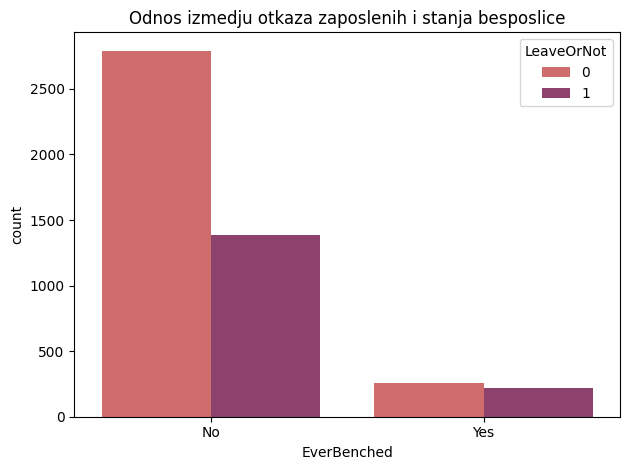

In [555]:
sns.countplot(x='EverBenched', hue='LeaveOrNot', data=df,palette='flare')
plt.title('Odnos izmedju otkaza zaposlenih i stanja besposlice')
plt.tight_layout()
plt.show()

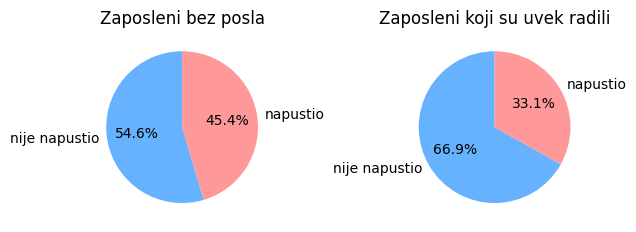

In [556]:
count_table = pd.crosstab(index=df['EverBenched'], columns=df['LeaveOrNot'])

left_not_left_benched = count_table.loc['Yes'].tolist()
left_not_left_not_benched = count_table.loc['No'].tolist()

vrednosti = ["nije napustio", "napustio"]

boje = ['#66B2FF','#FF9999']

plt.subplot(1, 2, 1)
plt.pie(left_not_left_benched, labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Zaposleni bez posla')

plt.subplot(1, 2, 2)
plt.pie(left_not_left_not_benched, labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Zaposleni koji su uvek radili')

plt.tight_layout()

plt.show()


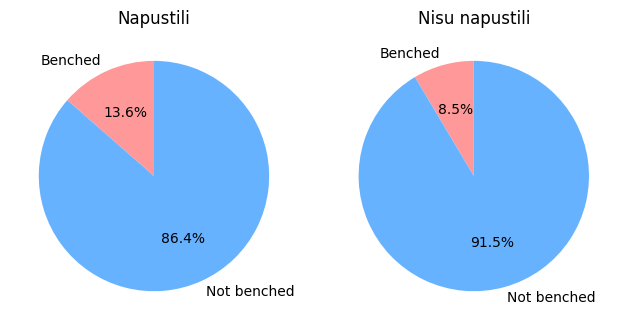

In [557]:
count_table = pd.crosstab(index=[df['LeaveOrNot'], df['EverBenched']], columns='count')


left_benched_not_benched = count_table.loc[(1, 'Yes'), 'count'].tolist()
left_not_benched_not_benched = count_table.loc[(1, 'No'), 'count'].tolist()
not_left_benched_not_benched = count_table.loc[(0, 'Yes'), 'count'].tolist()
not_left_not_benched_not_benched = count_table.loc[(0, 'No'), 'count'].tolist()


vrednosti = ['Benched', 'Not benched']

boje = ['#FF9999', '#66B2FF']

plt.subplot(1, 2, 1)
plt.pie([left_benched_not_benched, left_not_benched_not_benched], labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Napustili')

plt.subplot(1, 2, 2)
plt.pie([not_left_benched_not_benched, not_left_not_benched_not_benched], labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Nisu napustili')

plt.tight_layout()

plt.show()



Iz podataka se vidi kako su radnici koji su uvek imali posla naklonjeniji da ostanu.

### Raspodela polova

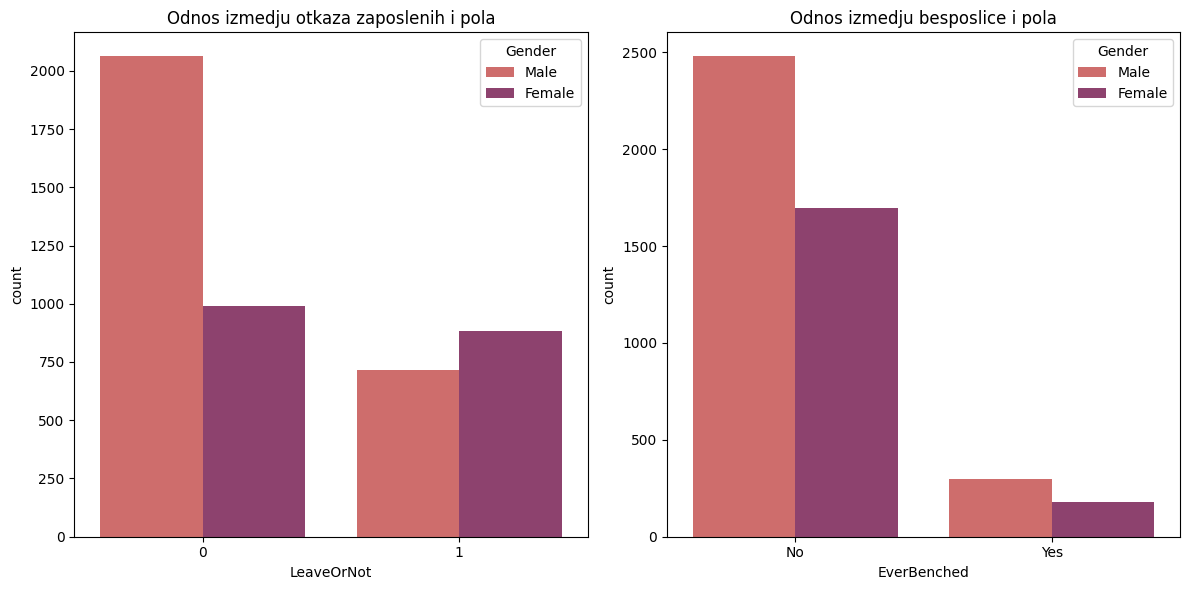

In [558]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='LeaveOrNot', hue='Gender', data=df,palette='flare')
plt.title('Odnos izmedju otkaza zaposlenih i pola')

plt.subplot(1, 2, 2)
sns.countplot(x='EverBenched', hue='Gender', data=df,palette='flare')
plt.title('Odnos izmedju besposlice i pola')
plt.tight_layout()
plt.show()

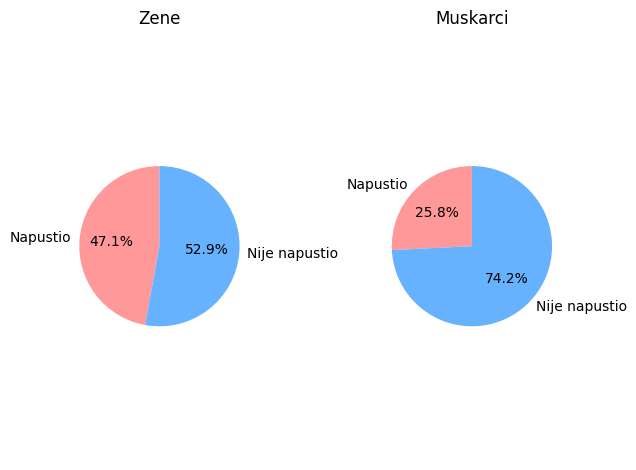

In [559]:
female_employees = df[df['Gender'] == 'Female']
male_employees = df[df['Gender'] == 'Male']

total_female = len(female_employees)
left_female = len(female_employees[female_employees['LeaveOrNot'] == 1])
not_left_female = total_female - left_female

total_male = len(male_employees)
left_male = len(male_employees[male_employees['LeaveOrNot'] == 1])
not_left_male = total_male - left_male

fig, axs = plt.subplots(1, 2)

axs[0].pie([left_female, not_left_female], labels=['Napustio', 'Nije napustio'], colors=boje,
           autopct='%1.1f%%', startangle=90)
axs[0].set_title('Zene')

axs[1].pie([left_male, not_left_male], labels=['Napustio', 'Nije napustio'], colors=boje,
           autopct='%1.1f%%', startangle=90)
axs[1].set_title('Muskarci')

axs[0].axis('equal')
axs[1].axis('equal')
plt.tight_layout()
plt.show()

Sa grafika se moze zakljuciti kako zene mnogo cesce daju otkaz od muskaraca.

### Raspodela godina

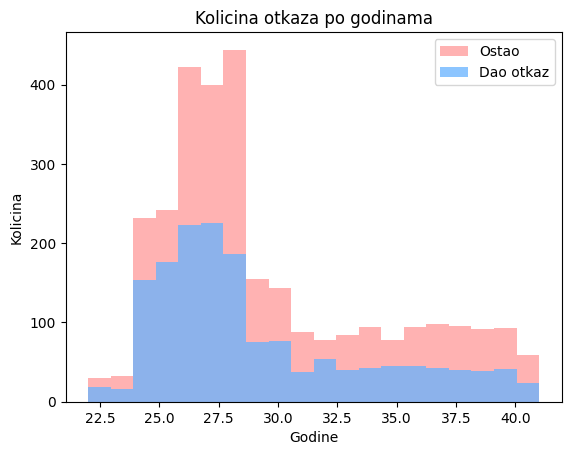

In [560]:
plt.figure()
plt.hist(df[df['LeaveOrNot'] == 0]['Age'], alpha=0.75, label='Ostao', bins=20,color=boje[0])
plt.hist(df[df['LeaveOrNot'] == 1]['Age'], alpha=0.75, label='Dao otkaz', bins=20,color=boje[1])
plt.xlabel('Godine')
plt.ylabel('Kolicina')
plt.legend()
plt.title('Kolicina otkaza po godinama')
plt.show()


<Figure size 1500x600 with 0 Axes>

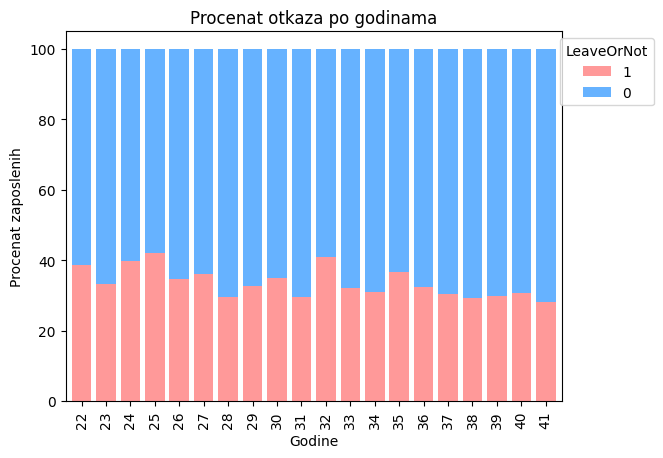

In [561]:
percentage_leave_by_age = df.groupby(['Age', 'LeaveOrNot']).size().unstack().div(df.groupby('Age').size(), axis=0) * 100
percentage_leave_by_age[0] = 100 - percentage_leave_by_age[1].fillna(0)

percentage_leave_by_age = percentage_leave_by_age.loc[:, ::-1]

plt.figure(figsize=(15, 6))
percentage_leave_by_age.plot(kind='bar', stacked=True, color=[ '#FF9999','#66B2FF'], width=0.8)

plt.xlabel('Godine')
plt.ylabel('Procenat zaposlenih')
plt.title('Procenat otkaza po godinama')
plt.legend(title='LeaveOrNot', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

### Uticaj plate i nivoa obrazovanja

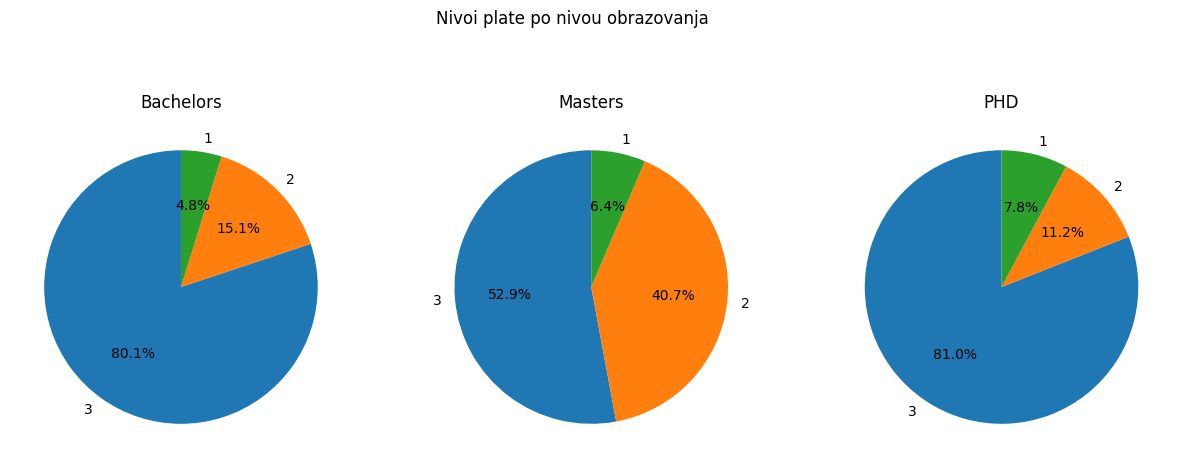

In [562]:
education_levels = df['Education'].unique()

fig, axs = plt.subplots(1, len(education_levels), figsize=(15, 5))

for i, education_level in enumerate(education_levels):
    subset = df[df['Education'] == education_level]
    payment_tier_counts = subset['PaymentTier'].value_counts()

    axs[i].pie(payment_tier_counts, labels=payment_tier_counts.index, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f'{education_level}')

plt.suptitle('Nivoi plate po nivou obrazovanja', y=1.05)
plt.show()

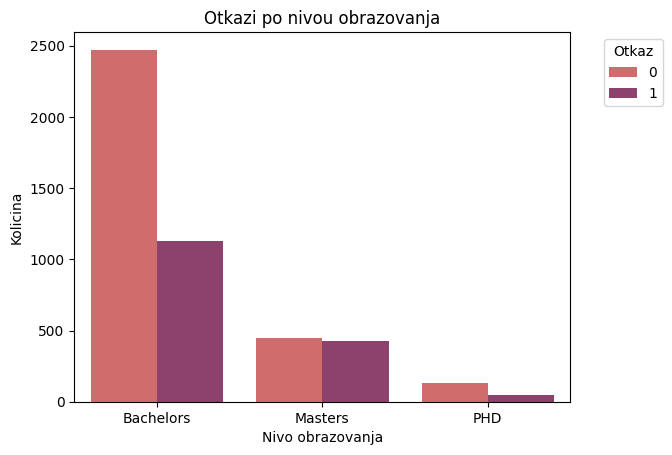

In [563]:
plt.figure()
sns.countplot(x='Education', hue='LeaveOrNot', data=df,palette='flare')
plt.xlabel('Nivo obrazovanja')
plt.ylabel('Kolicina')
plt.title('Otkazi po nivou obrazovanja')
plt.legend(title='Otkaz', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

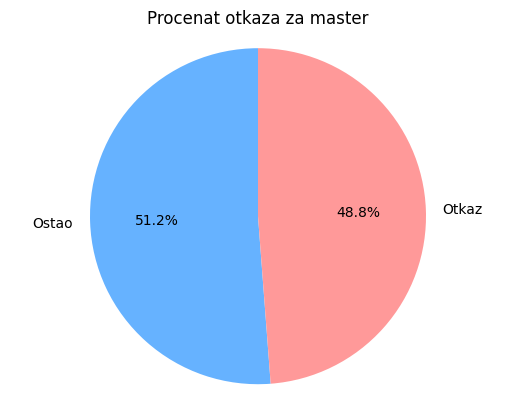

In [564]:
master_employees = df[df['Education'] == 'Masters']
leave_not_leave_counts = master_employees['LeaveOrNot'].value_counts()
vrednosti = ['Ostao','Otkaz']
plt.figure()
plt.pie(leave_not_leave_counts, labels=vrednosti, autopct='%1.1f%%', startangle=90,
        colors=['#66B2FF','#FF9999'])
plt.title('Procenat otkaza za master')
plt.axis('equal')
plt.show()

Vidi se da skoro polovina zaposlenih sa masterom odlucuje da napusti firmu.

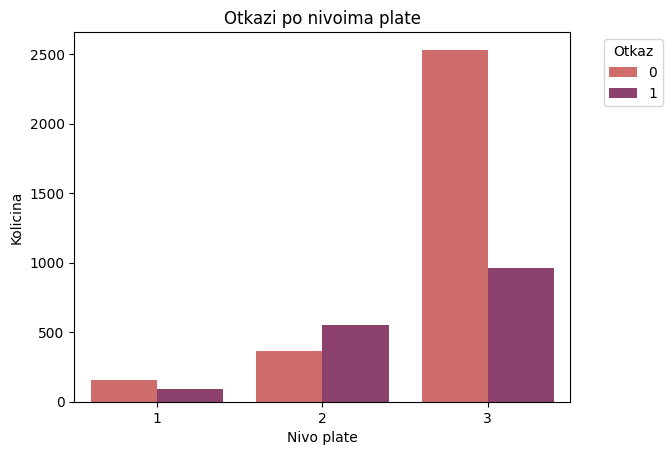

In [565]:
plt.figure()
sns.countplot(x='PaymentTier', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Nivo plate')
plt.ylabel('Kolicina')
plt.title('Otkazi po nivoima plate')
plt.legend(title='Otkaz', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

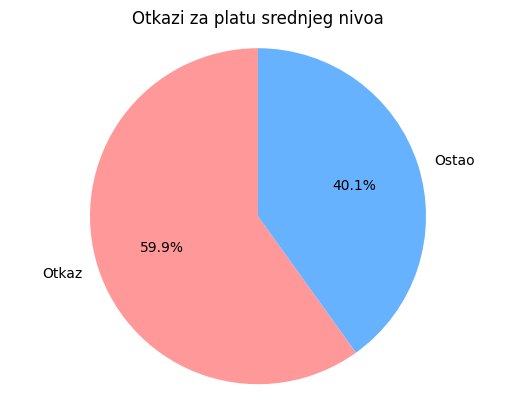

In [566]:
payment_tier_2_employees = df[df['PaymentTier'] == 2]

leave_not_leave_counts = payment_tier_2_employees['LeaveOrNot'].value_counts()
vrednosti = ['Otkaz','Ostao']
plt.figure()
plt.pie(leave_not_leave_counts, labels=vrednosti, autopct='%1.1f%%', startangle=90,
        colors=['#FF9999', '#66B2FF'])
plt.title('Otkazi za platu srednjeg nivoa')
plt.axis('equal')
plt.show()


Cak 60% zaposlenih koji su imali srednji nivo plate su se odlucili za otkaz.

### Uticaj godina rada u firmi

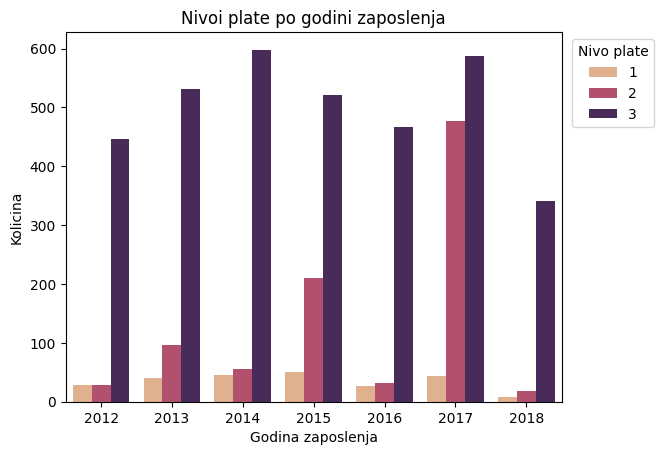

In [567]:
plt.figure()
sns.countplot(x='JoiningYear', hue='PaymentTier', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Kolicina')
plt.title('Nivoi plate po godini zaposlenja')
plt.legend(title='Nivo plate', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

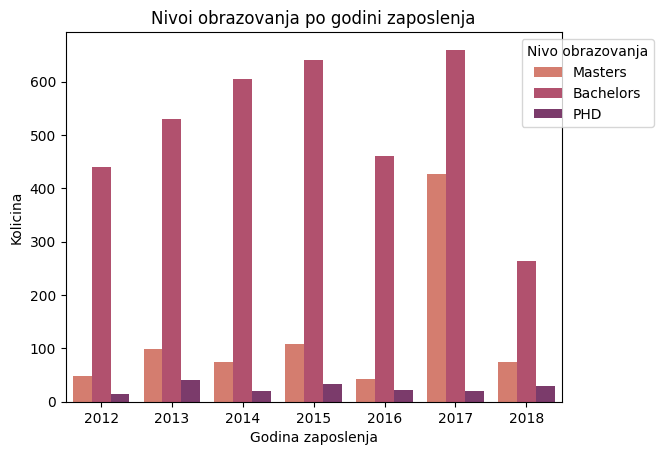

In [568]:
plt.figure()
sns.countplot(x='JoiningYear', hue='Education', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Kolicina')
plt.title('Nivoi obrazovanja po godini zaposlenja')
plt.legend(title='Nivo obrazovanja', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

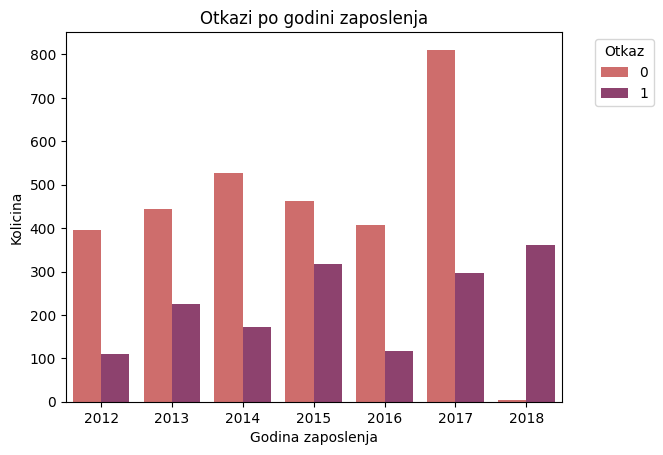

In [569]:
plt.figure()
sns.countplot(x='JoiningYear', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Kolicina')
plt.title('Otkazi po godini zaposlenja')
plt.legend(title='Otkaz', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

<Figure size 640x480 with 0 Axes>

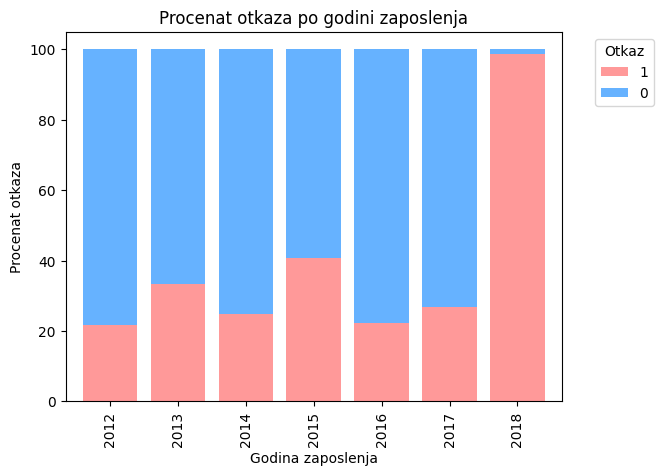

In [570]:
percentage_leave_by_year = df.groupby(['JoiningYear', 'LeaveOrNot']).size().unstack().div(df.groupby('JoiningYear').size(), axis=0) * 100
percentage_leave_by_year[0] = 100 - percentage_leave_by_year[1].fillna(0)

percentage_leave_by_year = percentage_leave_by_year.loc[:, ::-1]

plt.figure()
percentage_leave_by_year.plot(kind='bar', stacked=True, color=['#FF9999','#66B2FF'], width=0.8)

plt.xlabel('Godina zaposlenja')
plt.ylabel('Procenat otkaza')
plt.title('Procenat otkaza po godini zaposlenja')
plt.legend(title='Otkaz', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

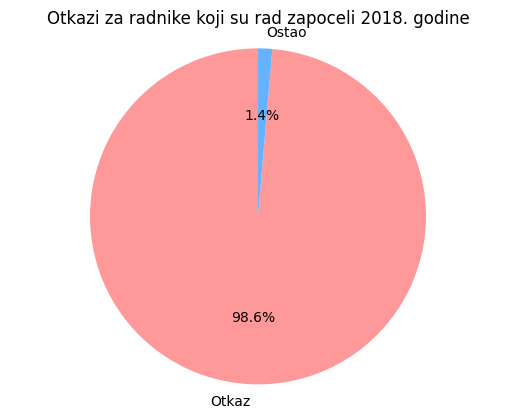

In [571]:
joined_2018_employees = df[df['JoiningYear'] == 2018]

leave_not_leave_counts = joined_2018_employees['LeaveOrNot'].value_counts()
plt.figure()
plt.pie(leave_not_leave_counts, labels=["Otkaz","Ostao"], autopct='%1.1f%%', startangle=90,
        colors=['#FF9999', '#66B2FF'])
plt.title('Otkazi za radnike koji su rad zapoceli 2018. godine')
plt.axis('equal') 
plt.show()

Grafik prikazuje kako su skoro svi zaposleni koji su se pridruzili kompaniji 2018. godine dali otkaz.

### Lokacija zaposlenih

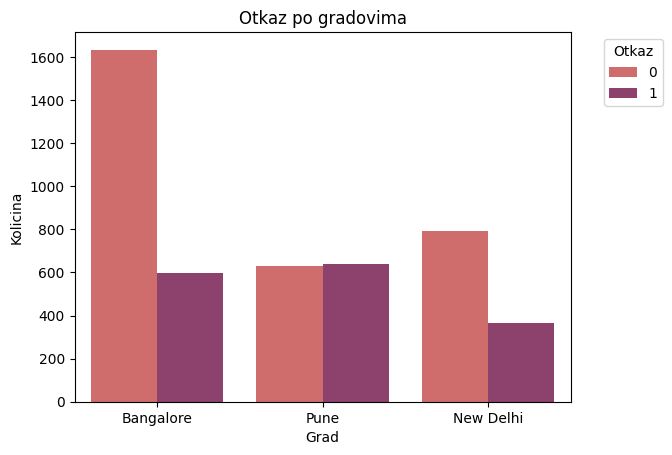

In [572]:
plt.figure()
sns.countplot(x='City', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Grad')
plt.ylabel('Kolicina')
plt.title('Otkaz po gradovima')
plt.legend(title='Otkaz', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

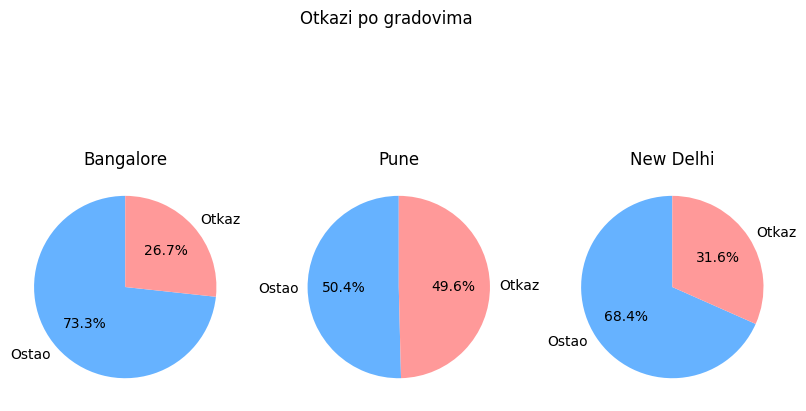

In [573]:
cities = df['City'].unique()

fig, axs = plt.subplots(1, len(cities), figsize=(10, 5))

for i, city in enumerate(cities):
    subset = df[df['City'] == city]
    leave_counts = subset['LeaveOrNot'].value_counts()

    axs[i].pie(leave_counts, labels=["Ostao","Otkaz"],colors=['#66B2FF','#FF9999'], autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f'{city}')

plt.suptitle('Otkazi po gradovima', y=1.05)
plt.show()

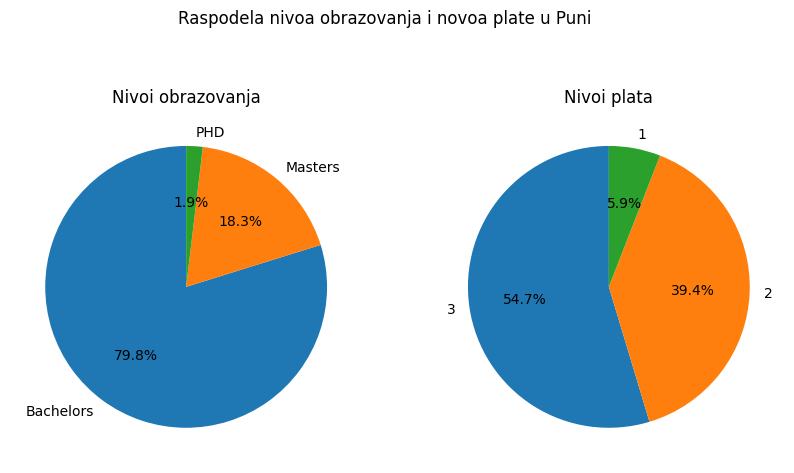

In [574]:
pune_data = df[df['City'] == 'Pune']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

education_counts = pune_data['Education'].value_counts()
axs[0].pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Nivoi obrazovanja')

payment_tier_counts = pune_data['PaymentTier'].value_counts()
axs[1].pie(payment_tier_counts, labels=payment_tier_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Nivoi plata')

plt.suptitle('Raspodela nivoa obrazovanja i novoa plate u Puni', y=1.05)
plt.show()

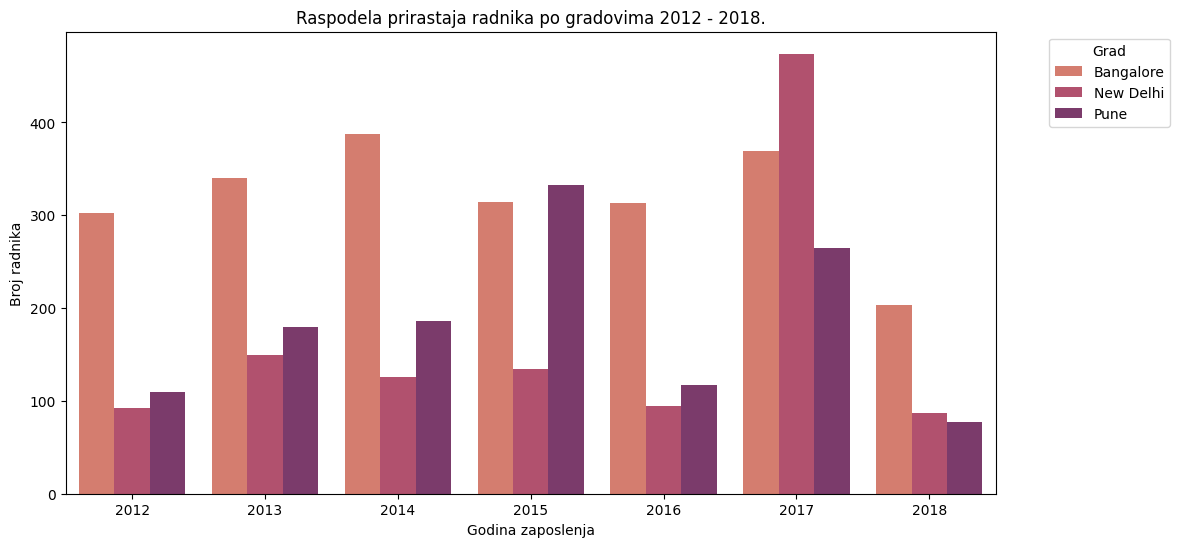

In [575]:
plt.figure(figsize=(12, 6))
sns.countplot(x='JoiningYear', hue='City', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Broj radnika')
plt.title('Raspodela prirastaja radnika po gradovima 2012 - 2018.')
plt.legend(title='Grad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

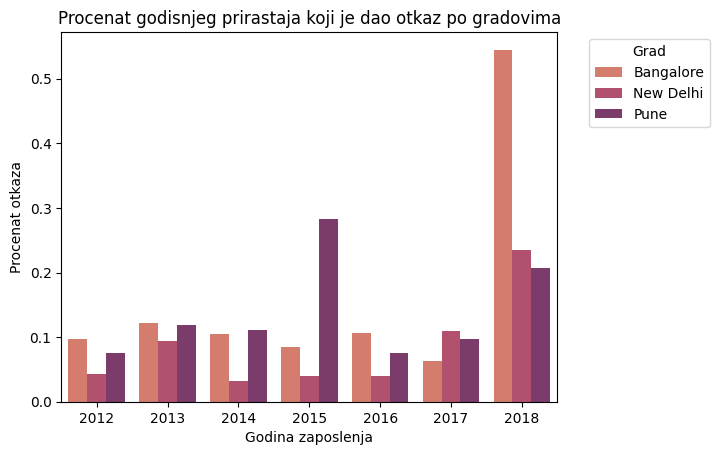

In [576]:
joined_left = df[df['LeaveOrNot'] == 1]

df_percentages = (joined_left.groupby(['JoiningYear', 'City']).size() / df.groupby('JoiningYear').size()).reset_index(name='Percentage')

plt.figure()
sns.barplot(x='JoiningYear', y='Percentage', hue='City', data=df_percentages, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Procenat otkaza')
plt.title('Procenat godisnjeg prirastaja koji je dao otkaz po gradovima')
plt.legend(title='Grad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Zaposleni su najzadovoljniji u Nju Delhiju, dok su najnezadovoljniji radnici koji su se zaposlili 2018. godine u Bangaloru. Uopste najnezadovoljniji su radnici iz Pune i Bangalora, dok Puna ima najveci procenat otkaza usled nezadovoljstva radnika koji su se zaposlili 2015. godine, sto je bio drugi najveci godisnji prirastaj radnika posle 2017.

### Uticaj iskustva u struci na otkaz zaposlenog

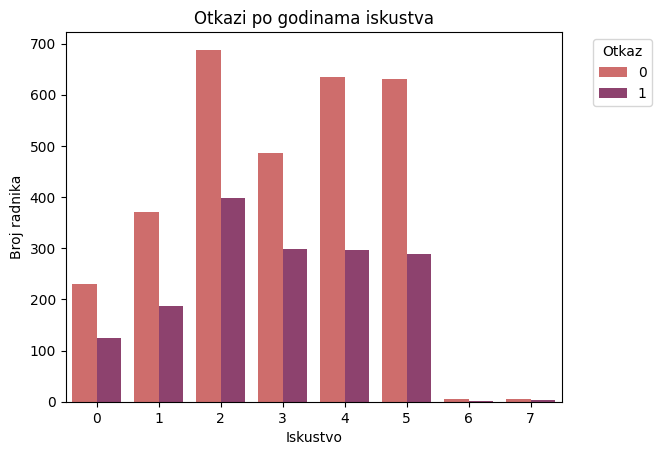

In [577]:
plt.figure()
sns.countplot(x='ExperienceInCurrentDomain', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Iskustvo')
plt.ylabel('Broj radnika')
plt.title('Otkazi po godinama iskustva')
plt.legend(title='Otkaz', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

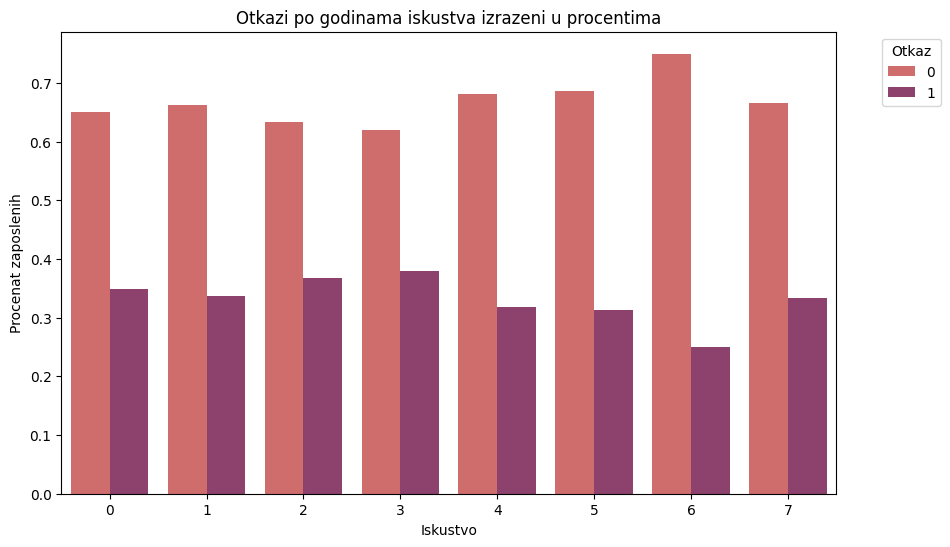

In [578]:
df_percentages = (df.groupby(['ExperienceInCurrentDomain', 'LeaveOrNot']).size() / df.groupby('ExperienceInCurrentDomain').size()).reset_index(name='Percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='ExperienceInCurrentDomain', y='Percentage', hue='LeaveOrNot', data=df_percentages, palette='flare')
plt.xlabel('Iskustvo')
plt.ylabel('Procenat zaposlenih')
plt.title('Otkazi po godinama iskustva izrazeni u procentima')
plt.legend(title='Otkaz', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Primeti se kako je procenat otkaza veciniski ujednacen kroz godine iskustva.

## Treniranje klasifikacionog modela

### Hi-kvadratni test

Za odabir parametara se ne mogu koristiti klasicne metode linearne regresije, jer se posmatraju kategoricni parametri. Zato postoji Hi-kvadratni test koji govori o medjusobnoj zavisnosti parametara. Test rezultuje p-vrednoscu, gde je uobicajeno da se smatra da medjusobna zavisnost postoji ukoliko je p-vrednost manja od 0.05 (sa 95% sigurnosti se garantuje postojanje zavisnosti).

Prvo je potrebno kategoricke vrednosti pretvoriti u numericke.

In [579]:
for column in df.columns:
    df[column] = LabelEncoder().fit_transform(df[column])

In [580]:
for klasa in df.columns:
    contingency_table = pd.crosstab(df['LeaveOrNot'], df[klasa])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"p-vrednost za Hi-kvadratni test za {klasa}: {p:.5f}")

p-vrednost za Hi-kvadratni test za Education: 0.00000
p-vrednost za Hi-kvadratni test za JoiningYear: 0.00000
p-vrednost za Hi-kvadratni test za City: 0.00000
p-vrednost za Hi-kvadratni test za PaymentTier: 0.00000
p-vrednost za Hi-kvadratni test za Age: 0.01228
p-vrednost za Hi-kvadratni test za Gender: 0.00000
p-vrednost za Hi-kvadratni test za EverBenched: 0.00000
p-vrednost za Hi-kvadratni test za ExperienceInCurrentDomain: 0.05011
p-vrednost za Hi-kvadratni test za LeaveOrNot: 0.00000


Svi parametri osim iskustva daju p-vrednost <= 0.05, dok je iskustvo na granici, tako da bi trebalo proveriti performase modela koji koriste i koji zanemaruju radni staz.

### Podela podataka

Potrebno je sve podatke iz skupa podataka podeliti na trening, test i validacioni skup u odnosu 60/20/20.

In [581]:

x = df.drop('LeaveOrNot', axis=1) 
y = df['LeaveOrNot'] 

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Broj zaposlenih u trening skupu: {len(y_train)}")
print(f"Broj zaposlenih u validacionom skupu: {len(y_valid)}")
print(f"Broj zaposlenih u testnom skupu: {len(y_test)}")

Broj zaposlenih u trening skupu: 2791
Broj zaposlenih u validacionom skupu: 931
Broj zaposlenih u testnom skupu: 931


### Trening modela

Bice korisceni modeli logisticke regresije, decission tree, random forest i xg boost.

In [582]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Pravljenje predikcija nad validacionim modelom.

In [583]:
logreg_valid_preds = logreg_model.predict(x_valid)
dt_valid_preds = dt_model.predict(x_valid)
rf_valid_preds = rf_model.predict(x_valid)
xgb_valid_preds = xgb_model.predict(x_valid)

Mera preciznosti klasifikacionih modela se razlikuje u odnosu na mera linearne regresije. Kod posmatranja preciznosti modela se posmatra koliko puta je odluka radnika da da otkaz uspesno i neuspesno predvidjena, kao i mera uspeha da model predvidi da ce zaposleni ostati u okviru firme.

In [584]:
print("Preciznost logisticke regresije:", accuracy_score(y_valid, logreg_valid_preds))
print("Preciznost stabla odluke:", accuracy_score(y_valid, dt_valid_preds))
print("Random forest preciznost:", accuracy_score(y_valid, rf_valid_preds))
print("Preciznost Extreme gradient boosting:", accuracy_score(y_valid, xgb_valid_preds))


Preciznost logisticke regresije: 0.706766917293233
Preciznost stabla odluke: 0.8098818474758325
Random forest preciznost: 0.8335123523093448
Preciznost Extreme gradient boosting: 0.841031149301826


Preciznost je izuzetno visoka i jasno se vidi razlika u performansama izmedju algoritama. Na osnovu p-vrednosti Hi-kvadratnog testa potrebno je proveriti uticaj zanemarivanja godina iskustva na performanse modela.

In [585]:
x_train = x_train.drop("ExperienceInCurrentDomain", axis=1)
x_valid = x_valid.drop("ExperienceInCurrentDomain", axis=1)


logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)

logreg_valid_preds = logreg_model.predict(x_valid)
dt_valid_preds = dt_model.predict(x_valid)
rf_valid_preds = rf_model.predict(x_valid)
xgb_valid_preds = xgb_model.predict(x_valid)

print("Preciznost logisticke regresije:", accuracy_score(y_valid, logreg_valid_preds))
print("Preciznost stabla odluke:", accuracy_score(y_valid, dt_valid_preds))
print("Random forest preciznost:", accuracy_score(y_valid, rf_valid_preds))
print("Preciznost Extreme gradient boosting:", accuracy_score(y_valid, xgb_valid_preds))


Preciznost logisticke regresije: 0.7099892588614393
Preciznost stabla odluke: 0.8313641245972073
Random forest preciznost: 0.8335123523093448
Preciznost Extreme gradient boosting: 0.8506981740064447


In [586]:
rf_feature_importances = pd.DataFrame({'Parametar': x_train.columns, 'Uticaj': rf_model.feature_importances_})
rf_feature_importances = rf_feature_importances.sort_values(by='Uticaj', ascending=False)
print(rf_feature_importances)

     Parametar    Uticaj
1  JoiningYear  0.323180
4          Age  0.237739
2         City  0.119566
3  PaymentTier  0.112652
0    Education  0.096611
5       Gender  0.092051
6  EverBenched  0.018201


In [587]:
x_train = x_train.drop("Age", axis=1)
x_valid = x_valid.drop("Age", axis=1)


logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)

logreg_valid_preds = logreg_model.predict(x_valid)
dt_valid_preds = dt_model.predict(x_valid)
rf_valid_preds = rf_model.predict(x_valid)
xgb_valid_preds = xgb_model.predict(x_valid)

print("Preciznost logisticke regresije:", accuracy_score(y_valid, logreg_valid_preds))
print("Preciznost stabla odluke:", accuracy_score(y_valid, dt_valid_preds))
print("Random forest preciznost:", accuracy_score(y_valid, rf_valid_preds))
print("Preciznost Extreme gradient boosting:", accuracy_score(y_valid, xgb_valid_preds))

Preciznost logisticke regresije: 0.6992481203007519
Preciznost stabla odluke: 0.8453276047261009
Random forest preciznost: 0.8485499462943072
Preciznost Extreme gradient boosting: 0.8506981740064447


In [588]:
x_test = x_test.drop("ExperienceInCurrentDomain", axis=1)
x_test = x_test.drop("Age", axis=1)

# Logistic Regression
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)
logreg_valid_preds = logreg_model.predict(x_valid)
logreg_test_preds = logreg_model.predict(x_test)
print("Logistic Regression Accuracy on Validation Set:", accuracy_score(y_valid, logreg_valid_preds))
print("Logistic Regression Accuracy on Test Set:", accuracy_score(y_test, logreg_test_preds))

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)
dt_valid_preds = dt_model.predict(x_valid)
dt_test_preds = dt_model.predict(x_test)
print("Decision Tree Accuracy on Validation Set:", accuracy_score(y_valid, dt_valid_preds))
print("Decision Tree Accuracy on Test Set:", accuracy_score(y_test, dt_test_preds))

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)
rf_valid_preds = rf_model.predict(x_valid)
rf_test_preds = rf_model.predict(x_test)
print("Random Forest Accuracy on Validation Set:", accuracy_score(y_valid, rf_valid_preds))
print("Random Forest Accuracy on Test Set:", accuracy_score(y_test, rf_test_preds))

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)
xgb_valid_preds = xgb_model.predict(x_valid)
xgb_test_preds = xgb_model.predict(x_test)
print("XGBoost Accuracy on Validation Set:", accuracy_score(y_valid, xgb_valid_preds))
print("XGBoost Accuracy on Test Set:", accuracy_score(y_test, xgb_test_preds))

Logistic Regression Accuracy on Validation Set: 0.6992481203007519
Logistic Regression Accuracy on Test Set: 0.6981740064446831
Decision Tree Accuracy on Validation Set: 0.8453276047261009
Decision Tree Accuracy on Test Set: 0.832438238453276
Random Forest Accuracy on Validation Set: 0.8485499462943072
Random Forest Accuracy on Test Set: 0.8292158968850698
XGBoost Accuracy on Validation Set: 0.8506981740064447
XGBoost Accuracy on Test Set: 0.8292158968850698


In [236]:
from sklearn.feature_selection import chi2, SelectKBest
le = LabelEncoder()
df = pd.read_csv("Employee.csv")

df_encoded = df.apply(le.fit_transform)

# Extract features and target variable
X = df_encoded.drop('LeaveOrNot', axis=1)
y = df_encoded['LeaveOrNot']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the chi-square test for feature selection
chi2_selector = SelectKBest(chi2, k=5)
X_train_chi2 = chi2_selector.fit_transform(X_train, y_train)

# Get selected features
selected_features_chi2 = X.columns[chi2_selector.get_support()]
print(selected_features_chi2)
# Train a classifier on the selected features
clf_chi2 = RandomForestClassifier(random_state=42)
clf_chi2.fit(X_train_chi2, y_train)

# Make predictions on the test set
X_test_chi2 = chi2_selector.transform(X_test)
y_pred_chi2 = clf_chi2.predict(X_test_chi2)

# Evaluate the model
accuracy_chi2 = accuracy_score(y_test, y_pred_chi2)#8539205155746509
print(f'Accuracy with chi-square selected features: {accuracy_chi2}')

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Gender'], dtype='object')
Accuracy with chi-square selected features: 0.8539205155746509


In [237]:
mi_selector = SelectKBest(mutual_info_classif, k='all')  # Choose 'k' based on your preference or use a specific number
X_train_mi = mi_selector.fit_transform(X_train, y_train)

# Get selected features
selected_features_mi = X.columns[mi_selector.get_support()]

# Train a classifier on the selected features
clf_mi = RandomForestClassifier(random_state=42)
clf_mi.fit(X_train_mi, y_train)

# Make predictions on the test set
X_test_mi = mi_selector.transform(X_test)
y_pred_mi = clf_mi.predict(X_test_mi)

# Evaluate the model
accuracy_mi = accuracy_score(y_test, y_pred_mi)
print(f'Accuracy with mutual information selected features: {accuracy_mi}')

Accuracy with mutual information selected features: 0.849624060150376


In [238]:


# Create and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions on the validation set
logreg_valid_preds = logreg_model.predict(X_valid)
dt_valid_preds = dt_model.predict(X_valid)
rf_valid_preds = rf_model.predict(X_valid)
xgb_valid_preds = xgb_model.predict(X_valid)

# Evaluate the models on the validation set
print("Logistic Regression Accuracy:", accuracy_score(y_valid, logreg_valid_preds))
print("Decision Tree Accuracy:", accuracy_score(y_valid, dt_valid_preds))
print("Random Forest Accuracy:", accuracy_score(y_valid, rf_valid_preds))
print("XGBoost Accuracy:", accuracy_score(y_valid, xgb_valid_preds))

# Additional evaluation metrics
print("\nClassification Report - Logistic Regression:")
print(classification_report(y_valid, logreg_valid_preds))

print("\nClassification Report - Decision Tree:")
print(classification_report(y_valid, dt_valid_preds))

print("\nClassification Report - Random Forest:")
print(classification_report(y_valid, rf_valid_preds))

print("\nClassification Report - XGBoost:")
print(classification_report(y_valid, xgb_valid_preds))


logreg_test_preds = logreg_model.predict(X_test)
dt_test_preds = dt_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)

# Evaluate the models on the test set
print("Logistic Regression Accuracy (Test):", accuracy_score(y_test, logreg_test_preds))
print("Decision Tree Accuracy (Test):", accuracy_score(y_test, dt_test_preds))
print("Random Forest Accuracy (Test):", accuracy_score(y_test, rf_test_preds))
print("XGBoost Accuracy (Test):", accuracy_score(y_test, xgb_test_preds))

# Additional evaluation metrics on the test set
print("\nClassification Report - Logistic Regression (Test):")
print(classification_report(y_test, logreg_test_preds))

print("\nClassification Report - Decision Tree (Test):")
print(classification_report(y_test, dt_test_preds))

print("\nClassification Report - Random Forest (Test):")
print(classification_report(y_test, rf_test_preds))

print("\nClassification Report - XGBoost (Test):")
print(classification_report(y_test, xgb_test_preds))

ValueError: could not convert string to float: 'Bachelors'

<Figure size 1000x600 with 0 Axes>

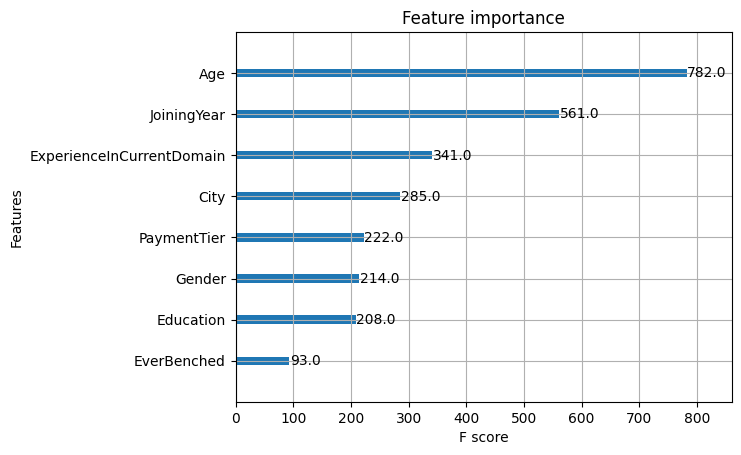

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model)
plt.show()

                     Feature  Importance
1                JoiningYear    0.306547
4                        Age    0.175283
2                       City    0.126162
3                PaymentTier    0.099440
0                  Education    0.095324
7  ExperienceInCurrentDomain    0.092716
5                     Gender    0.086819
6                EverBenched    0.017710
